In this notebook, I'll go through a full example of using bpnet-multi to analyze some chip-nexus data. These are the same data that were used in our original paper: Avsec, Ž., Weilert, M., Shrikumar, A. et al. Base-resolution models of transcription-factor binding reveal soft motif syntax. Nat Genet 53, 354–366 (2021). https://doi.org/10.1038/s41588-021-00782-6

You can download the data from https://zenodo.org/record/3371216#.Y0muwFLMKAQ , but be aware that it's 30 GB of data. 
I (Charles McAnany) also have a local copy at Stowers, so if you're at Stowers, just let me know and I'll point you in the right direction. 
I've copied the idr-optimal-set.summit.bed files and the counts.neg.bw and counts.pos.bw files from the downloaded data into my working directory. 

In [ ]:
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,4]
plt.rcParams['figure.dpi'] = 150
import numpy as np
import pyBigWig
import pysam
import h5py
import os


In [ ]:
#Here, I'll set a few constants that will be applicable throughout the project. 
WORKING_DIRECTORY="/scratch/cm2363/oskn-demo"
SRC_DIR="/n/projects/cm2363/chrombpnet-heavy/src"
GENOME_FASTA=WORKING_DIRECTORY + "/data/all_chr.fa"
TF_NAMES = ["oct4", "sox2", "klf4", "nanog"] #The names of the factors we'll use. For consistency, I'm always going to use lowercase. 
TEST_CHROMS = ["chr" + str(x) for x in [1,8,9]]
VAL_CHROMS = ["chr" + str(x) for x in [2,3,4]]
TRAIN_CHROMS = ["chr" + str(x) for x in [5,6,7,10,11,12,13,14,15,16,17,18,19]]

In [3]:
!ls -l {WORKING_DIRECTORY}

total 12
drwxr-xr-x 2 cm2363 Domain Users  273 Nov 18 12:33 bed
drwxr-xr-x 2 cm2363 Domain Users 4096 Nov 17 11:23 data
drwxr-xr-x 2 cm2363 Domain Users  112 Nov 17 14:24 input
drwxr-xr-x 2 cm2363 Domain Users 4096 Nov 18 09:50 json
drwxr-xr-x 9 cm2363 Domain Users  336 Nov 17 18:56 models
drwxr-xr-x 2 cm2363 Domain Users 4096 Nov 18 09:54 pred
drwxr-xr-x 2 cm2363 Domain Users   10 Nov 17 14:06 shap


In [4]:
!ls -lh {WORKING_DIRECTORY}/data

total 6.1G
-rw-r----- 1 cm2363 Domain Users 2.6G Oct 14 14:49 all_chr.fa
-rw-r--r-- 1 cm2363 Domain Users 2.5K Oct 14 14:49 all_chr.fa.fai
-rw-r----- 1 cm2363 Domain Users 350M Oct 14 13:52 klf4.neg.bw
-rw-r----- 1 cm2363 Domain Users 350M Oct 14 13:56 klf4.pos.bw
-rw-r----- 1 cm2363 Domain Users 1.4M Oct 14 13:57 klf4.summit.bed
-rw-r----- 1 cm2363 Domain Users 398M Oct 14 13:58 nanog.neg.bw
-rw-r----- 1 cm2363 Domain Users 398M Oct 14 13:59 nanog.pos.bw
-rw-r----- 1 cm2363 Domain Users 1.3M Oct 14 13:58 nanog.summit.bed
-rw-r----- 1 cm2363 Domain Users 551M Oct 14 13:57 oct4.neg.bw
-rw-r----- 1 cm2363 Domain Users 551M Oct 14 13:57 oct4.pos.bw
-rw-r----- 1 cm2363 Domain Users 604K Oct 14 13:58 oct4.summit.bed
-rw-r----- 1 cm2363 Domain Users 154M Oct 14 13:59 patchcap.neg.bw
-rw-r----- 1 cm2363 Domain Users 154M Oct 14 13:59 patchcap.pos.bw
-rw-r----- 1 cm2363 Domain Users 301M Oct 14 13:58 sox2.neg.bw
-rw-r----- 1 cm2363 Domain Users 300M Oct 14 13:58 sox2.pos.bw
-rw-r----- 1 cm2363

In [ ]:
#The first thing I need to do is prepare input files in order to train a bias model. 
#But what shall I use for bias? I have two options: I can either use background regions from the actual chip-nexus experiments,
#or I can use the patchcap track. 
#If I were to use background regions, I'd have to have a stringent way to determine when a region is not bound, and the data
#are noisy enough that this might be a tough call. I'll train up the bias model on patchcap data instead. 

#In order to train that model, I'll need a couple things:
# 1. The bias data. I'm going to just use the patchcap bigwigs from the paper, no biggie. 
# 2. A set of regions to train on. I'll make these in a minute. 
# 3. A model architecture. I have to decide on this right now, because it will determine the size of the regions I train on. 

#I'll use a standard BPNet architecture, but with few filters since it's learning something so simple. 
#With a 9-layer network, and a 25 bp input filter and 25 bp output filter, using 1000 bp output windows, I can calculate the input size:

In [1]:
OUTPUT_LENGTH=1000
input_length_str = !{SRC_DIR}/lengthCalc.py --output-len {OUTPUT_LENGTH} --n-dil-layers 9 --conv1-kernel-size 25 --profile-kernel-size 25
INPUT_LENGTH=int(input_length_str[0])
print(INPUT_LENGTH)
RECEPTIVE_FIELD=INPUT_LENGTH - OUTPUT_LENGTH+1
print(RECEPTIVE_FIELD)
MAX_JITTER = 100

3092
2093


In [ ]:
#Okay, great. I need to make sure that the regions I train on have valid DNA within 3092/2 bases of the middle of the window. 
#For clarity, here are some dimensions:

#
#
#            |<---  2093 bp (Receptive field) --->|
#   |<--------------------   3092 bp (Input length) ----------------------->|
#   SEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCE
#   \        \                                    /                        /
#     \        \                                /                        /
#       \        \                            /                        / 
#         \        \                        /                        / 
#           \        \                    /                        / 
#             \        \                /                        / 
#               \        \            /                        / 
#                 \        \        /                        / 
#                   \        \    /                        /
#                     \        \/                        /
#                      PROFILEPROFILEPROFILEPROFILEPROFIL
#                      |<--- 1000 bp (Output length) --->|
#    |<--- 1046 bp --->|
#
# During training, we also shift the regions around by a little bit, a process called jittering. We'll use a maximum jitter of 100.

In [ ]:
#In order to generate bias regions, I need to get the actual training regions. This is not really part of bpnet-multi, but 
#I do have a few utility scripts in the repo to help with this. 
#I'm going to combine the called peaks, make sure there's valid genome under all of them (i.e., no "N" nucleotides within the receptive field.),
#then split them into train, validation, and test splits. 


In [6]:
bigwigFileNames = [WORKING_DIRECTORY + "/data/" + tfName + "." + strand + ".bw" for tfName in TF_NAMES for strand in ["pos", "neg"]]
print(bigwigFileNames)
summitBedFnames = [WORKING_DIRECTORY + "/data/" + tfName + ".summit.bed" for tfName in TF_NAMES]
print(summitBedFnames)
#And I need to make bigwig specs, for the upcoming json. The bigwig spec needs to list max and min quantiles. 
bwSpec = [{"file-name" : fname, "max-quantile" : 1, "min-counts" : 1} for fname in bigwigFileNames]

['/scratch/cm2363/oskn-demo/data/oct4.pos.bw', '/scratch/cm2363/oskn-demo/data/oct4.neg.bw', '/scratch/cm2363/oskn-demo/data/sox2.pos.bw', '/scratch/cm2363/oskn-demo/data/sox2.neg.bw', '/scratch/cm2363/oskn-demo/data/klf4.pos.bw', '/scratch/cm2363/oskn-demo/data/klf4.neg.bw', '/scratch/cm2363/oskn-demo/data/nanog.pos.bw', '/scratch/cm2363/oskn-demo/data/nanog.neg.bw']
['/scratch/cm2363/oskn-demo/data/oct4.summit.bed', '/scratch/cm2363/oskn-demo/data/sox2.summit.bed', '/scratch/cm2363/oskn-demo/data/klf4.summit.bed', '/scratch/cm2363/oskn-demo/data/nanog.summit.bed']


In [7]:
prepareBedPeaksConfig = {
    "bigwigs" : bwSpec, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : summitBedFnames},
    "genome" : GENOME_FASTA,
    "write-counts-to" : WORKING_DIRECTORY + "/bed/peak_all.stats", 
    "output-length" : OUTPUT_LENGTH,
    "input-length" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/peak", 
    "resize-mode" : "center", 
    "verbosity" : "INFO"}

with open(WORKING_DIRECTORY + "/json/prepareBedPeaks.json", "w") as fp:
    json.dump(prepareBedPeaksConfig, fp, indent=4)
    print(json.dumps(prepareBedPeaksConfig, indent=4))

{
    "bigwigs": [
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/oct4.pos.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/oct4.neg.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/sox2.pos.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/sox2.neg.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/klf4.pos.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/klf4.neg.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/nanog.po

In [10]:
#Now we can go ahead and run that script. 
!{SRC_DIR}/prepareBed.py {WORKING_DIRECTORY}/json/prepareBedPeaks.json

INFO:root:Starting bed file generation.
INFO:root:Training regions: 90970
INFO:root:Validation regions: 29277
INFO:root:Testing regions: 27727
INFO:root:Rejected on loading: 2934
INFO:root:Validating training regions.
  0%|                                                | 0/431240 [00:00<?, ?it/s]
INFO:root:Validated inflated regions. Surviving regions: 53905
100%|█████████████████████████████████| 431240/431240 [01:00<00:00, 7095.23it/s]
INFO:root:Total surviving regions: 53899
INFO:root:Validating validation regions.
  0%|                                                | 0/138216 [00:00<?, ?it/s]
INFO:root:Validated inflated regions. Surviving regions: 17277
100%|█████████████████████████████████| 138216/138216 [00:19<00:00, 7122.62it/s]
INFO:root:Total surviving regions: 17275
INFO:root:Validating testing regions.
  0%|                                                | 0/129616 [00:00<?, ?it/s]
INFO:root:Validated inflated regions. Surviving regions: 16202
100%|██████████████████████

In [11]:
import pybedtools
def generateTilingRegions(genome, width, chromEdgeBoundary, spaceBetween, allowChroms):
    chromRegions = []
    numRegions = 0
    #To use window_maker from pybedtools, I first need to create a bed containing the chromosomes where I want regions made. 
    for chrom in genome.references:
        if(chrom not in allowChroms):
            continue
         
        startPos = chromEdgeBoundary
        chromSize = genome.get_reference_length(chrom)
        stopPos = chromSize - chromEdgeBoundary
        chromRegions.append(pybedtools.Interval(chrom, startPos, stopPos))
     
    windows = pybedtools.BedTool(chromRegions).window_maker(w=width, s=spaceBetween + width, genome='mm10')
    return windows

with pysam.FastaFile(GENOME_FASTA) as genomeFp:
    w = generateTilingRegions(genomeFp, 1000, 100000, 50000, TEST_CHROMS + TRAIN_CHROMS + VAL_CHROMS)
    peaks = pybedtools.BedTool(WORKING_DIRECTORY + "/bed/peak_all.bed")
    peaksReject = pybedtools.BedTool(WORKING_DIRECTORY + "/bed/peak_reject.bed")
    allPeaks = peaks.cat(peaksReject).sort().slop(b=INPUT_LENGTH, genome='mm10')
    trimWindows = w.subtract(allPeaks, A=True)
    print("Number of peak regions: {0:d}".format(allPeaks.count()))
    trimWindows.saveas(WORKING_DIRECTORY+ "/bed/tiling_all.bed")
    print("Background window candidates: {0:d}".format(trimWindows.count()))

Number of peak regions: 86709
Background window candidates: 42760


In [12]:
#Now that we have a bed file with all of our training regions in it, we can generate the background regions that we'll train the bias model on. 
#Note that even though I'm using patchcap data for my bias track, I'm still going to train the bias model on unbound regions, so that any effect 
#TF binding has on patchcap doesn't show up in my bias model. 
#This is another script I wrote, it generates tiling regions across the whole genome and then removes regions that overlap your peak set, 
#and also only outputs regions that fall in a set percentile of counts. 

biasBigwigFnames = [WORKING_DIRECTORY + "/data/patchcap" + "." + strand + ".bw" for strand in ["pos", "neg"]]
print(biasBigwigFnames)



['/scratch/cm2363/oskn-demo/data/patchcap.pos.bw', '/scratch/cm2363/oskn-demo/data/patchcap.neg.bw']


In [13]:
biasBwSpec = [{"file-name" : fname, "max-quantile" : 0.6, "min-quantile" : 0.01} for fname in bigwigFileNames]
biasBwSpec = biasBwSpec + [{"file-name" : fname, "max-quantile" : 0.95, "min-quantile" : 0.1} for fname in biasBigwigFnames]
prepareBedNonPeaksConfig = {
    "bigwigs" : biasBwSpec, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : [WORKING_DIRECTORY + "/bed/tiling_all.bed"]},
    "genome" : GENOME_FASTA,
    "write-counts-to" : WORKING_DIRECTORY + "/bed/nonpeak_all.stats", 
    "output-length" : OUTPUT_LENGTH,
    "input-length" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/nonpeak", 
    "resize-mode" : "center", 
    "verbosity" : "INFO"}

with open(WORKING_DIRECTORY + "/json/prepareBedNonPeaks.json", "w") as fp:
    json.dump(prepareBedNonPeaksConfig, fp)
    print(json.dumps(prepareBedNonPeaksConfig, indent=4))

{
    "bigwigs": [
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/oct4.pos.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/oct4.neg.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/sox2.pos.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/sox2.neg.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/klf4.pos.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/scratch/cm2363/oskn-demo/data/klf4.neg.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name"

In [14]:
#Now we can go ahead and run that script. 
!{SRC_DIR}/prepareBed.py {WORKING_DIRECTORY}/json/prepareBedNonPeaks.json

INFO:root:Starting bed file generation.
INFO:root:Training regions: 23220
INFO:root:Validation regions: 7629
INFO:root:Testing regions: 6850
INFO:root:Rejected on loading: 5061
INFO:root:Validating training regions.
100%|█████████████████████████████████| 223460/223460 [00:30<00:00, 7229.14it/s]
INFO:root:Total surviving regions: 6638
INFO:root:Validating validation regions.
100%|███████████████████████████████████| 73890/73890 [00:10<00:00, 7205.45it/s]
INFO:root:Total surviving regions: 2102
INFO:root:Validating testing regions.
100%|███████████████████████████████████| 66340/66340 [00:09<00:00, 7191.93it/s]
INFO:root:Total surviving regions: 2080
INFO:root:Regions saved.


# Building the training dataset

In [15]:
#This next step is pretty easy; we just need to pull the sequence and profile information into a single hdf5-format file for the training programs to use. 

#We'll need to make training and validation sets for both the nonpeaks and peaks bed files. 


for split in ["train", "val"]:
    for dataset in ["peak", "nonpeak"]:
        heads = []
        for tfName in TF_NAMES:
            if(dataset == 'peak'):
                heads.append({"bigwig-files" : [WORKING_DIRECTORY + "/data/" + tfName + ".pos.bw",
                                    WORKING_DIRECTORY + "/data/" + tfName + ".neg.bw"]})
            else:
                heads.append({"bigwig-files" : [WORKING_DIRECTORY + "/data/patchcap.pos.bw", 
                                            WORKING_DIRECTORY + "/data/patchcap.neg.bw"]})
        config = {"genome" : GENOME_FASTA, 
                  "input-length" : INPUT_LENGTH,
                  "output-length" : OUTPUT_LENGTH,
                  "max-jitter" : MAX_JITTER,
                  "regions" : WORKING_DIRECTORY + "/bed/" + dataset + "_" + split + ".bed",
                  "output-h5" : WORKING_DIRECTORY + "/input/" + dataset + "_" + split + ".h5",
                  "heads" : heads,
                  "verbosity" : "DEBUG"}
        configFname =WORKING_DIRECTORY + "/json/prepareInput" + dataset + "_" + split+ ".json" 
        with open(configFname, "w") as fp:
            json.dump(config, fp)
        !{SRC_DIR}/prepareTrainingData.py {configFname}
        
            


DEBUG:root:Sequence dataset created.
DEBUG:root:Added data for head 0
DEBUG:root:Added data for head 1
DEBUG:root:Added data for head 2
DEBUG:root:Added data for head 3
DEBUG:root:Sequence dataset created.
DEBUG:root:Added data for head 0
DEBUG:root:Added data for head 1
DEBUG:root:Added data for head 2
DEBUG:root:Added data for head 3
DEBUG:root:Sequence dataset created.
DEBUG:root:Added data for head 0
DEBUG:root:Added data for head 1
DEBUG:root:Added data for head 2
DEBUG:root:Added data for head 3
DEBUG:root:Sequence dataset created.
DEBUG:root:Added data for head 0
DEBUG:root:Added data for head 1
DEBUG:root:Added data for head 2
DEBUG:root:Added data for head 3


# Training the bias model

In [ ]:
#Okay, so the bed preparation step is done. I didn't spend much time on that since it will be specific to every system you deal with. 
#But now comes the common stuff. And it's (honestly) easier. 

In [16]:
#To make the model config file, I'll assemble the heads first. 
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "patchcap_" + tfName,
                  "counts-loss-weight" : 10})
#print(heads)

#And now the whole config file:
biasTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/solo", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "max-jitter" : 100,
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "patchcap",
            "model-args" : "",
            "filters" : 16,
            "layers" : 9,
            "input-filter-width" : 25,
            "output-filter-width" : 25
        }
    },
    "train-data" : WORKING_DIRECTORY + "/input/nonpeak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/nonpeak_val.h5",
    "heads" : heads,
    "verbosity" : "WARNING"
}

print(json.dumps(biasTrainConfig, indent=4))

with open(WORKING_DIRECTORY + "/json/trainBias.json", "w") as fp:
    json.dump(biasTrainConfig, fp)
    

{
    "settings": {
        "output-prefix": "/scratch/cm2363/oskn-demo/models/solo",
        "epochs": 200,
        "early-stopping-patience": 20,
        "batch-size": 128,
        "learning-rate": 0.004,
        "learning-rate-plateau-patience": 5,
        "max-jitter": 100,
        "architecture": {
            "architecture-name": "bpnet",
            "input-length": 3092,
            "output-length": 1000,
            "model-name": "patchcap",
            "model-args": "",
            "filters": 16,
            "layers": 9,
            "input-filter-width": 25,
            "output-filter-width": 25
        }
    },
    "train-data": "/scratch/cm2363/oskn-demo/input/nonpeak_train.h5",
    "val-data": "/scratch/cm2363/oskn-demo/input/nonpeak_val.h5",
    "heads": [
        {
            "num-tasks": 2,
            "profile-loss-weight": 1,
            "head-name": "patchcap_oct4",
            "counts-loss-weight": 10
        },
        {
            "num-tasks": 2,
            "pro

In [17]:
!{SRC_DIR}/trainSoloModel.py {WORKING_DIRECTORY}/json/trainBias.json

2022-11-18 15:28:07.825857: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 15:28:08.677341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21010 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:d8:00.0, compute capability: 7.5
Epoch 1/200
2022-11-18 15:28:14.165143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300

Epoch 1: val_loss improved from inf to 417.64667, saving model to /scratch/cm2363/oskn-demo/models/solo.checkpoint.model
2022-11-18 15:28:21.633351: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consid

In [ ]:
#(I've deleted many pages of output from the training program)
#We should look at how well the model did. 

In [18]:
!{SRC_DIR}/makeLossPlots.py --json {WORKING_DIRECTORY}/models/solo.history.json --output img/solo.png

In [ ]:
#It's pretty clear that the model overlearned, even with only sixteen filters. Interesting. 
#It would be great if the training and validation losses were more similar, but it's not a lethal flaw since we don't need to interpret the bias model. 
#We should, however, make predictions from it and calculate some metrics. 

# Evaluating the bias model

In [20]:
#First, we need to make predictions with the bias model. That's another json file...
biasPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/patchcap.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/solo.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}


with open(WORKING_DIRECTORY + "/json/predictBias.json", "w") as fp:
    json.dump(biasPredictConfig, fp)

In [21]:
!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictBias.json

INFO:root:GPU memory growth enabled.
DEBUG:root:Opening output hdf5 file.
INFO:root:Loading regions
INFO:root:Input prepared. Loading model.
INFO:root:Model loaded. Predicting.
683/683 [==============================] - 12s 12ms/step
INFO:root:Predictions complete. Writing hdf5.
INFO:root:Writing predictions
DEBUG:h5py._conv:Creating converter from 5 to 3
INFO:root:Datasets created. Populating regions.
INFO:root:Writing predictions.
100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]
INFO:root:File saved.


In [22]:
#And now I need to convert that hdf5 file into a bigwig.
!{SRC_DIR}/predictToBigwig.py --h5 {WORKING_DIRECTORY}/pred/patchcap.h5 --bw {WORKING_DIRECTORY}/pred/patchcap_positive.bw --head-id 0 --task-id 0 --mode profile --verbose
!{SRC_DIR}/predictToBigwig.py --h5 {WORKING_DIRECTORY}/pred/patchcap.h5 --bw {WORKING_DIRECTORY}/pred/patchcap_negative.bw --head-id 0 --task-id 1 --mode profile --verbose

INFO:root:Starting to write /scratch/cm2363/oskn-demo/pred/patchcap_positive.bw, head 0 task 0
INFO:root:Added header.
INFO:root:Loading coordinate data
INFO:root:Region data loaded. Sorting.
100%|████████████████████████████████| 87375/87375 [00:00<00:00, 1510337.33it/s]
INFO:root:Generated list of regions to sort.
INFO:root:Region order calculated.
INFO:root:Loading head data.
INFO:root:Starting to write data.
100%|███████████████████████████████████| 87375/87375 [00:22<00:00, 3915.75it/s]
INFO:root:Closing bigwig.
INFO:root:Bigwig closed.
INFO:root:Starting to write /scratch/cm2363/oskn-demo/pred/patchcap_negative.bw, head 0 task 1
INFO:root:Added header.
INFO:root:Loading coordinate data
INFO:root:Region data loaded. Sorting.
100%|████████████████████████████████| 87375/87375 [00:00<00:00, 1619230.99it/s]
INFO:root:Generated list of regions to sort.
INFO:root:Region order calculated.
INFO:root:Loading head data.
INFO:root:Starting to write data.
100%|███████████████████████████████

In [ ]:
#Note that I've only written bigwigs for the first head - since all heads were trained on the same data, I'm going to assume each head performed equally well.

In [23]:
#We can now calculate some standard metrics on our predictions, though we don't yet have anything to compare these to. 
!{SRC_DIR}/metrics.py --reference {WORKING_DIRECTORY}/data/patchcap.pos.bw --pred {WORKING_DIRECTORY}/pred/patchcap_positive.bw --regions {WORKING_DIRECTORY}/bed/peak_all.bed --threads 70 --apply-abs

reference /scratch/cm2363/oskn-demo/data/patchcap.pos.bw predicted /scratch/cm2363/oskn-demo/pred/patchcap_positive.bw regions /scratch/cm2363/oskn-demo/bed/peak_all.bed
100%|██████████████████████████████████| 87375/87375 [00:05<00:00, 15242.95it/s]
metric    	      0.000000%	     25.000000%	     50.000000%	     75.000000%	    100.000000%	regions
mnll      	   -2509.219343	     -83.188637	     -68.781396	     -54.642644	      -5.477282	87334
jsd       	       0.658074	       0.796333	       0.802821	       0.809079	       0.832097	87334
pearsonr  	      -0.058110	       0.048766	       0.076437	       0.105453	       0.413433	87334
spearmanr 	      -0.080622	       0.051209	       0.073062	       0.094140	       0.267197	87334
Counts pearson 	 -0.020721
Counts spearman	 -0.068418


In [101]:
#Let's also take a quick look at the generated bigwigs. 

def plotBws(bwNames, titles, chrom, start, stop):
    
    for i, bwName in enumerate(bwNames):
        plt.subplot(100*len(bwNames)+10+(i+1))
        bw = pyBigWig.open(bwName)
        bwVals = np.nan_to_num(bw.values(chrom, start, stop))
        #plt.xlim(0,stop-start)
        plt.bar(range(start, stop), bwVals, width=1)
        plt.ylabel(titles[i])
        if(i < len(bwNames)-1):
            plt.xticks([])
        

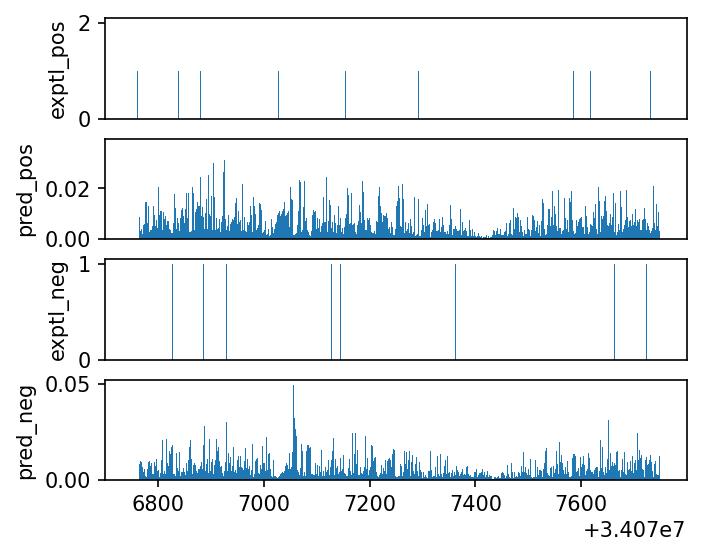

In [102]:
plotBws([WORKING_DIRECTORY + "/data/patchcap.pos.bw",
         WORKING_DIRECTORY + "/pred/patchcap_positive.bw",
         WORKING_DIRECTORY + "/data/patchcap.neg.bw", 
         WORKING_DIRECTORY + "/pred/patchcap_negative.bw"],
        ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], "chr1", 34076750, 34077750)

In [ ]:
#Huh. With so little patchcap data, it's really hard to tell if the model is doing a good job.
#In any event, it's time to train the transformation model up. 


# Training the transformation model

In [36]:
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "patchcap_" + tfName,
                  "counts-loss-weight" : 10})

transformationTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/transformation", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.04, #Note the very aggressive LR; we can do this because there are so few parameters. 
        "learning-rate-plateau-patience" : 5,
        "solo-model-file" : WORKING_DIRECTORY + "/models/solo.model",
        "sequence-input-length" : INPUT_LENGTH, 
        "output-length" : OUTPUT_LENGTH,
        "max-jitter" : 100,
        "profile-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]},
        "counts-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]}},
        
    "train-data" : WORKING_DIRECTORY+ "/input/peak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/peak_val.h5",
    "heads" : heads,
    "verbosity" : "INFO"
}

print(json.dumps(transformationTrainConfig, indent=2))

with open(WORKING_DIRECTORY + "/json/trainTransformation.json", "w") as fp:
    json.dump(transformationTrainConfig, fp)

{
  "settings": {
    "output-prefix": "/scratch/cm2363/oskn-demo/models/transformation",
    "epochs": 200,
    "early-stopping-patience": 20,
    "batch-size": 128,
    "learning-rate": 0.04,
    "learning-rate-plateau-patience": 5,
    "solo-model-file": "/scratch/cm2363/oskn-demo/models/solo.model",
    "sequence-input-length": 3092,
    "output-length": 1000,
    "max-jitter": 100,
    "profile-architecture": {
      "name": "simple",
      "types": [
        "linear",
        "sigmoid"
      ]
    },
    "counts-architecture": {
      "name": "simple",
      "types": [
        "linear",
        "sigmoid"
      ]
    }
  },
  "train-data": "/scratch/cm2363/oskn-demo/input/peak_train.h5",
  "val-data": "/scratch/cm2363/oskn-demo/input/peak_val.h5",
  "heads": [
    {
      "num-tasks": 2,
      "profile-loss-weight": 1,
      "head-name": "patchcap_oct4",
      "counts-loss-weight": 10
    },
    {
      "num-tasks": 2,
      "profile-loss-weight": 1,
      "head-name": "patchcap_s

In [37]:
!{SRC_DIR}/trainTransformationModel.py {WORKING_DIRECTORY}/json/trainTransformation.json

INFO:root:GPU memory growth enabled.
INFO:root:Initial load of dataset for hdf5-based generator.
INFO:root:Initial load of dataset for hdf5-based generator.
INFO:root:Generators initialized. Training.
Epoch 1/200
421/422 [============================>.] - ETA: 0s - loss: 3106.6272 - regress_sum_patchcap_oct4_profile_loss: 744.7723 - regress_sum_patchcap_sox2_profile_loss: 414.0269 - regress_sum_patchcap_klf4_profile_loss: 868.6361 - regress_sum_patchcap_nanog_profile_loss: 1058.3129 - regress_sum_patchcap_oct4_counts_loss: 0.3788 - regress_sum_patchcap_sox2_counts_loss: 0.2524 - regress_sum_patchcap_klf4_counts_loss: 0.8091 - regress_sum_patchcap_nanog_counts_loss: 0.6475
Epoch 1: val_loss improved from inf to 3121.52856, saving model to /scratch/cm2363/oskn-demo/models/transformation.checkpoint.model
2022-11-18 15:40:44.101128: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:ten

In [38]:
#Let's go ahead and make predictions...
transformPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/transform.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/transformation.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}

print(transformPredictConfig)

with open(WORKING_DIRECTORY + "/json/predictTransformation.json", "w") as fp:
    json.dump(transformPredictConfig, fp)


{'settings': {'genome': '/scratch/cm2363/oskn-demo/data/all_chr.fa', 'output-h5': '/scratch/cm2363/oskn-demo/pred/transform.h5', 'batch-size': 128, 'heads': 4, 'architecture': {'model-file': '/scratch/cm2363/oskn-demo/models/transformation.model', 'input-length': 3092, 'output-length': 1000}}, 'bed-file': '/scratch/cm2363/oskn-demo/bed/peak_all.bed', 'verbosity': 'DEBUG'}


In [39]:
!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictTransformation.json

INFO:root:GPU memory growth enabled.
DEBUG:root:Opening output hdf5 file.
INFO:root:Loading regions
INFO:root:Input prepared. Loading model.
INFO:root:Model loaded. Predicting.
683/683 [==============================] - 13s 14ms/step
INFO:root:Predictions complete. Writing hdf5.
INFO:root:Writing predictions
DEBUG:h5py._conv:Creating converter from 5 to 3
INFO:root:Datasets created. Populating regions.
INFO:root:Writing predictions.
100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]
INFO:root:File saved.


In [40]:
for i, tfName in enumerate(TF_NAMES):
    !{SRC_DIR}/predictToBigwig.py --h5 {WORKING_DIRECTORY}/pred/transform.h5 --bw {WORKING_DIRECTORY}/pred/{tfName}_transform_positive.bw --head-id {i} --task-id 0 --mode profile --verbose 
    !{SRC_DIR}/predictToBigwig.py --h5 {WORKING_DIRECTORY}/pred/transform.h5 --bw {WORKING_DIRECTORY}/pred/{tfName}_transform_negative.bw --head-id {i} --task-id 1 --mode profile --verbose --negate 

INFO:root:Starting to write /scratch/cm2363/oskn-demo/pred/oct4_transform_positive.bw, head 0 task 0
INFO:root:Added header.
INFO:root:Loading coordinate data
INFO:root:Region data loaded. Sorting.
100%|████████████████████████████████| 87375/87375 [00:00<00:00, 2325378.41it/s]
INFO:root:Generated list of regions to sort.
INFO:root:Region order calculated.
INFO:root:Loading head data.
INFO:root:Starting to write data.
100%|███████████████████████████████████| 87375/87375 [00:23<00:00, 3714.20it/s]
INFO:root:Closing bigwig.
INFO:root:Bigwig closed.
INFO:root:Starting to write /scratch/cm2363/oskn-demo/pred/oct4_transform_negative.bw, head 0 task 1
INFO:root:Added header.
INFO:root:Loading coordinate data
INFO:root:Region data loaded. Sorting.
100%|████████████████████████████████| 87375/87375 [00:00<00:00, 1346857.79it/s]
INFO:root:Generated list of regions to sort.
INFO:root:Region order calculated.
INFO:root:Loading head data.
INFO:root:Starting to write data.
100%|███████████████████

In [125]:
def plotTfBigwigs(tfName, exptName, startPos = 34066036, span=1000, chrom="chr1"):
    plotBws([WORKING_DIRECTORY + "/data/" + tfName + ".pos.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             WORKING_DIRECTORY + "/data/" + tfName + ".neg.bw", 
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw"],
            ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], chrom, startPos, startPos+span)

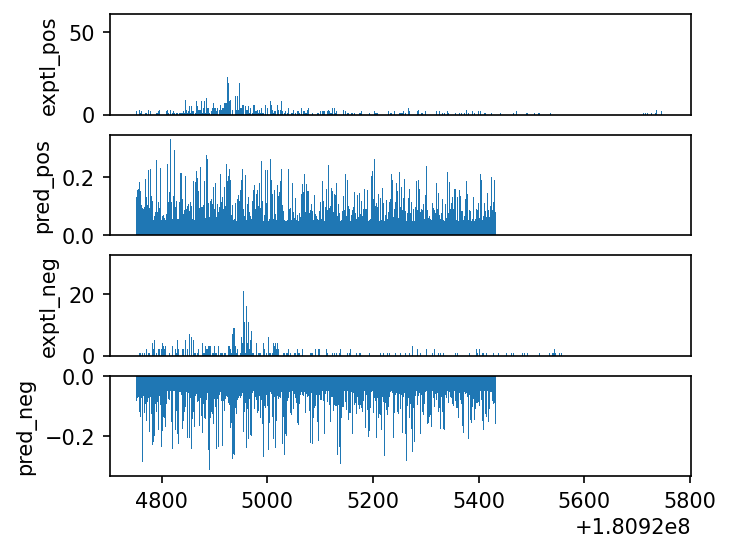

In [103]:
plotTfBigwigs('oct4', 'transform', startPos = 180924752)
#plotTfBigwigs('oct4', 'combined', startPos = 180924752, span=400)

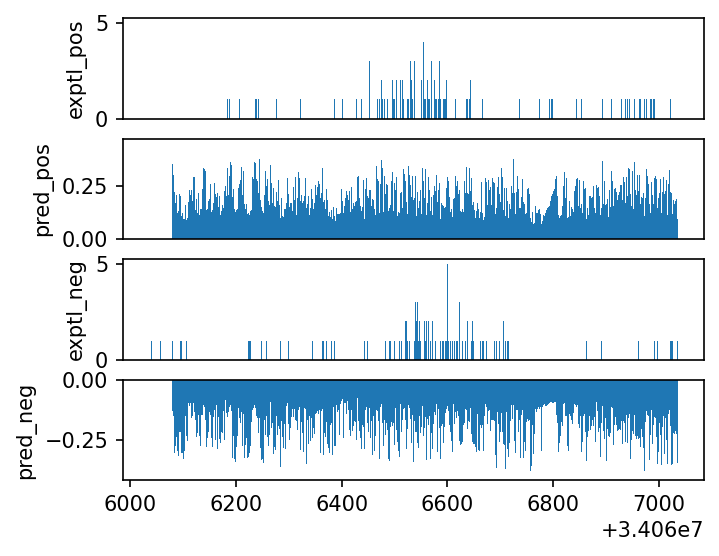

In [104]:
plotTfBigwigs('nanog', 'transform')

In [ ]:
#Of course these aren't a good match, but that's partly the point - the bald spot that the patchcap model predicts seems to also be present in the Nanog and Oct4 experimental data,
#and this suggests that that bald spot is an artifact. 

# Training the combined model

In [49]:
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "combined_" + tfName,
                  "counts-loss-weight" : 10,
                  "use-bias-counts" : False})


#And now the whole config file:
combinedTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/joint", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "max-jitter" : 100,
        "transformation-model" : {
            "transformation-model-file" : WORKING_DIRECTORY + "/models/transformation.model"
        },
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "joint",
            "model-args" : "",
            "filters" : 64,
            "layers" : 9,
            "input-filter-width" : 25,
            "output-filter-width" : 25
        }
    },
    "train-data" : WORKING_DIRECTORY + "/input/peak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/peak_val.h5",
    "heads" : heads,
    "verbosity" : "INFO"
}

print(json.dumps(combinedTrainConfig, indent=2))

with open(WORKING_DIRECTORY + "/json/trainCombined.json", "w") as fp:
    json.dump(combinedTrainConfig, fp)

{
  "settings": {
    "output-prefix": "/scratch/cm2363/oskn-demo/models/joint",
    "epochs": 200,
    "early-stopping-patience": 20,
    "batch-size": 128,
    "learning-rate": 0.004,
    "learning-rate-plateau-patience": 5,
    "max-jitter": 100,
    "transformation-model": {
      "transformation-model-file": "/scratch/cm2363/oskn-demo/models/transformation.model"
    },
    "architecture": {
      "architecture-name": "bpnet",
      "input-length": 3092,
      "output-length": 1000,
      "model-name": "joint",
      "model-args": "",
      "filters": 64,
      "layers": 9,
      "input-filter-width": 25,
      "output-filter-width": 25
    }
  },
  "train-data": "/scratch/cm2363/oskn-demo/input/peak_train.h5",
  "val-data": "/scratch/cm2363/oskn-demo/input/peak_val.h5",
  "heads": [
    {
      "num-tasks": 2,
      "profile-loss-weight": 1,
      "head-name": "combined_oct4",
      "counts-loss-weight": 10,
      "use-bias-counts": false
    },
    {
      "num-tasks": 2,
      

In [55]:
!{SRC_DIR}/trainCombinedModel.py {WORKING_DIRECTORY}/json/trainCombined.json

INFO:root:GPU memory growth enabled.
INFO:root:Initial load of dataset for hdf5-based generator.
INFO:root:Initial load of dataset for hdf5-based generator.
INFO:root:Generators initialized. Training.
Epoch 1/200
422/422 [==============================] - ETA: 0s - loss: 3166.3486 - combined_add_profile_combined_oct4_loss: 754.7055 - combined_add_profile_combined_sox2_loss: 421.9792 - combined_add_profile_combined_klf4_loss: 865.4936 - combined_add_profile_combined_nanog_loss: 1073.8124 - solo_logcounts_combined_oct4_loss: 1.1801 - solo_logcounts_combined_sox2_loss: 0.8141 - solo_logcounts_combined_klf4_loss: 1.2588 - solo_logcounts_combined_nanog_loss: 1.7828
Epoch 1: val_loss improved from inf to 3035.97974, saving model to /scratch/cm2363/oskn-demo/models/joint.checkpoint.model
2022-11-18 16:25:07.636317: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:tensorflow:Assets writte

In [56]:
#Let's look at the losses...
!{SRC_DIR}/makeLossPlots.py --json {WORKING_DIRECTORY}/models/joint.history.json --output img/joint.png

In [ ]:
#It's overfitting a bit, maybe next time I'll try with fewer filters. 
#But now's the time to make predictions. 

In [57]:
combinedPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/combined.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/joint_combined.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}

print(combinedPredictConfig)

with open(WORKING_DIRECTORY + "/json/predictCombined.json", "w") as fp:
    json.dump(combinedPredictConfig, fp)
#For the residual model, I just need to change a few terms:
residualPredictConfig = combinedPredictConfig
residualPredictConfig["settings"]["output-h5"] = WORKING_DIRECTORY + "/pred/residual.h5"
residualPredictConfig["settings"]["architecture"]["model-file"] = WORKING_DIRECTORY + "/models/joint_residual.model"
with open(WORKING_DIRECTORY + "/json/predictResidual.json", "w") as fp:
    json.dump(residualPredictConfig, fp)

{'settings': {'genome': '/scratch/cm2363/oskn-demo/data/all_chr.fa', 'output-h5': '/scratch/cm2363/oskn-demo/pred/combined.h5', 'batch-size': 128, 'heads': 4, 'architecture': {'model-file': '/scratch/cm2363/oskn-demo/models/joint_combined.model', 'input-length': 3092, 'output-length': 1000}}, 'bed-file': '/scratch/cm2363/oskn-demo/bed/peak_all.bed', 'verbosity': 'DEBUG'}


In [58]:
!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictCombined.json
!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictResidual.json

INFO:root:GPU memory growth enabled.
DEBUG:root:Opening output hdf5 file.
INFO:root:Loading regions
INFO:root:Input prepared. Loading model.
INFO:root:Model loaded. Predicting.
683/683 [==============================] - 38s 50ms/step
INFO:root:Predictions complete. Writing hdf5.
INFO:root:Writing predictions
DEBUG:h5py._conv:Creating converter from 5 to 3
INFO:root:Datasets created. Populating regions.
INFO:root:Writing predictions.
100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]
INFO:root:File saved.
INFO:root:GPU memory growth enabled.
DEBUG:root:Opening output hdf5 file.
INFO:root:Loading regions
INFO:root:Input prepared. Loading model.
INFO:root:Model loaded. Predicting.
683/683 [==============================] - 30s 39ms/step
INFO:root:Predictions complete. Writing hdf5.
INFO:root:Writing predictions
DEBUG:h5py._conv:Creating converter from 5 to 3
INFO:root:Datasets created. Populating regions.
INFO:root:Writing predictions.
100%|██████████████████

In [59]:
#Since rendering bigwigs takes so long, I'm going to make a little script to do it in parallel. 
commands = ["#!/usr/bin/env zsh\n"]
command_base = "{0:s}/predictToBigwig.py --h5 {1:s}/pred/{{0:s}}.h5 --bw {1:s}/pred/{{1:s}}.bw --head-id {{2:d}} --task-id {{3:d}} --mode profile {{4:s}} &\n"
command_here = command_base.format(SRC_DIR, WORKING_DIRECTORY)
print(command_here)
for i, tfName in enumerate(TF_NAMES):
    for taskid, taskname in enumerate(["positive", "negative"]):
        for modelname in ["combined", "residual"]:
            curCommand = command_here.format(modelname, tfName + "_" + modelname + "_" + taskname, i, taskid, "--negate" if taskid == 1 else "")
            commands.append(curCommand)
commands.append('wait\n')
print(commands)
with open(WORKING_DIRECTORY + "/pred/runCombined.zsh", "w") as fp:
    for c in commands:
        fp.write(c)


/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/{0:s}.h5 --bw /scratch/cm2363/oskn-demo/pred/{1:s}.bw --head-id {2:d} --task-id {3:d} --mode profile {4:s} &

['#!/usr/bin/env zsh\n', '/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/combined.h5 --bw /scratch/cm2363/oskn-demo/pred/oct4_combined_positive.bw --head-id 0 --task-id 0 --mode profile  &\n', '/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/residual.h5 --bw /scratch/cm2363/oskn-demo/pred/oct4_residual_positive.bw --head-id 0 --task-id 0 --mode profile  &\n', '/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/combined.h5 --bw /scratch/cm2363/oskn-demo/pred/oct4_combined_negative.bw --head-id 0 --task-id 1 --mode profile --negate &\n', '/n/projects/cm2363/chrombpnet-heavy/src/predictToBigwig.py --h5 /scratch/cm2363/oskn-demo/pred/residual.h5 --bw /

In [60]:
!chmod +x {WORKING_DIRECTORY}/pred/runCombined.zsh
!{WORKING_DIRECTORY}/pred/runCombined.zsh

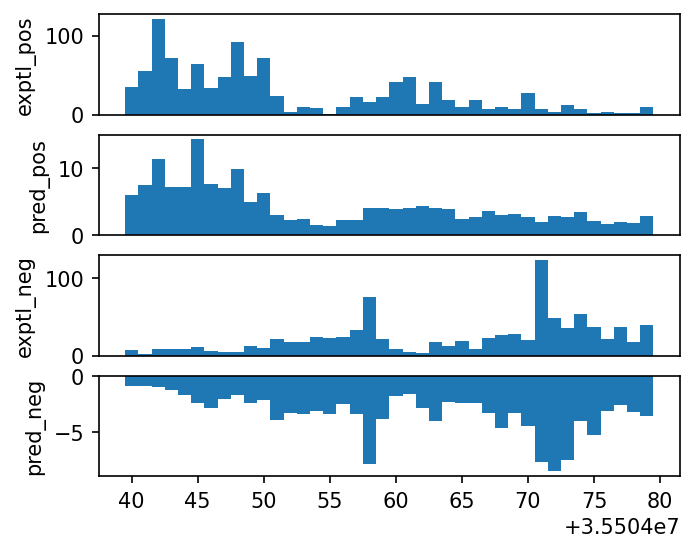

In [128]:
plotTfBigwigs('oct4', 'residual', startPos = 35504040, span=40, chrom="chr17")

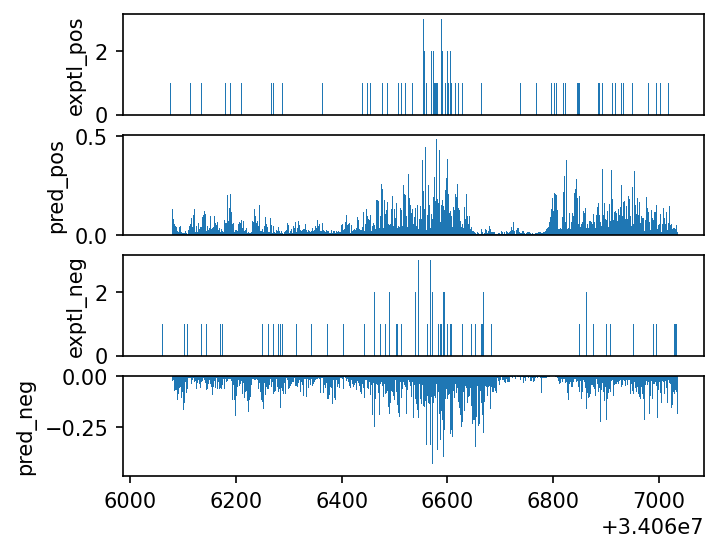

In [105]:
plotTfBigwigs('oct4', 'combined')

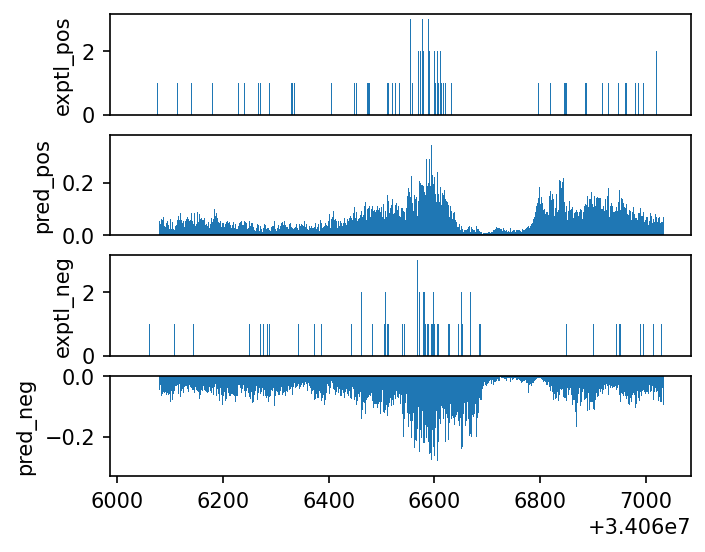

In [106]:
plotTfBigwigs('oct4', 'residual')

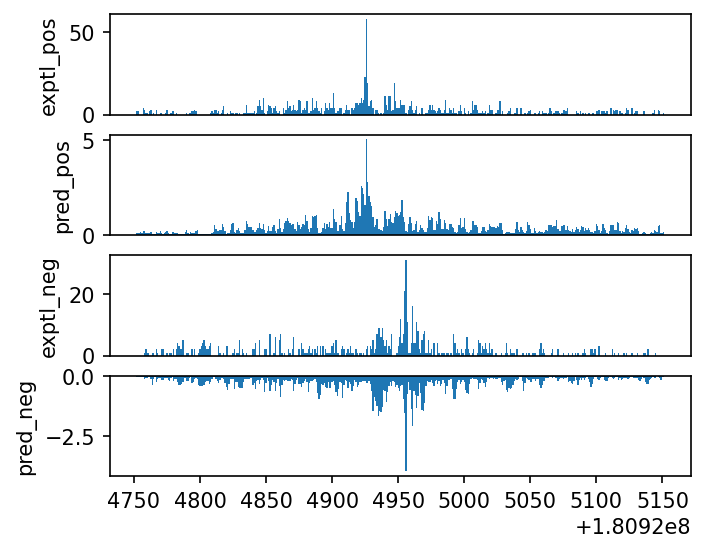

In [107]:
#Let's look around our favorite Lefty1 enhancer...
plotTfBigwigs('oct4', 'combined', startPos = 180924752, span=400)

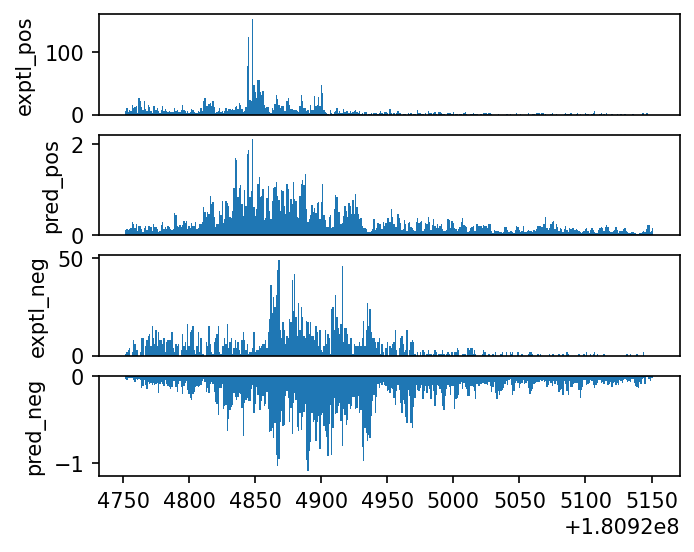

In [108]:
plotTfBigwigs('nanog', 'combined', startPos = 180924752, span=400)

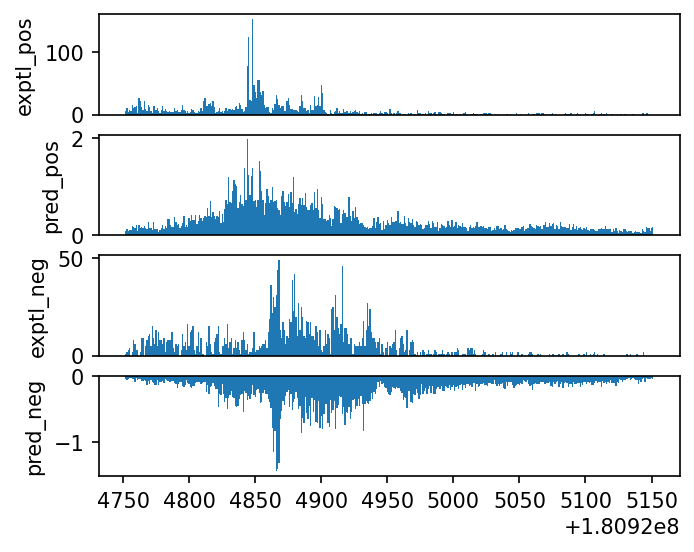

In [109]:
plotTfBigwigs('nanog', 'residual', startPos = 180924752, span=400)

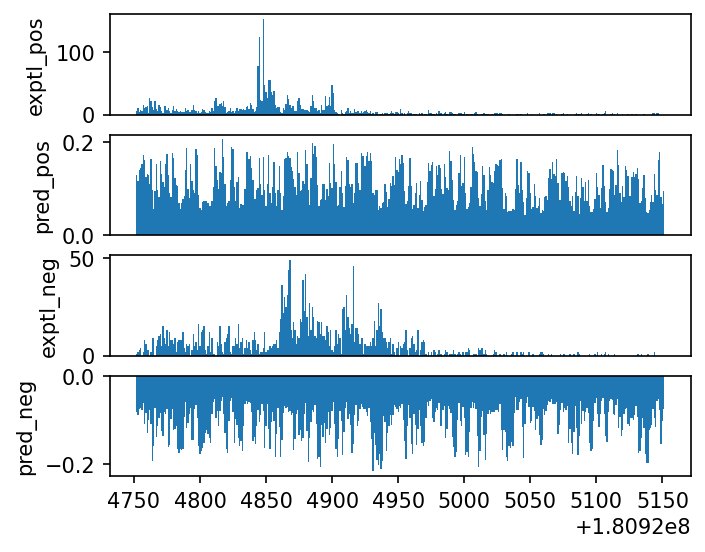

In [110]:
plotTfBigwigs('nanog', 'transform', startPos = 180924752, span=400)

# Deriving flat importance scores

In [67]:
#Importance scores are needed to run motif discovery, but they're also a great way to analyze what the model learned. 
#Unfortunately for us, they take a while to generate. 
def makeInterpretJson(tfNum):
    return {
        "genome" : GENOME_FASTA,
        "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
        "model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
        "input-length" : INPUT_LENGTH,
        "output-length" : OUTPUT_LENGTH,
        "heads" : 4,
        "head-id": tfNum,
        "profile-task-ids" : [0,1],
        "profile-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_profile.h5",
        "counts-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_counts.h5",
        "num-shuffles" : 20,
        "verbosity" : "DEBUG"}

for tfNum in range(len(TF_NAMES)):
    with open(WORKING_DIRECTORY + "/json/shap_" + TF_NAMES[tfNum] + ".json", "w") as fp:
        json.dump(makeInterpretJson(tfNum), fp)
        

In [68]:
for tfName in TF_NAMES:
    !{SRC_DIR}/interpretFlat.py {WORKING_DIRECTORY}/json/shap_{tfName}.json

INFO:root:GPU memory growth enabled.


INFO:root:AddV2used in model but handling of op is not specified by shap; will use original  gradients
INFO:root:StopGradientused in model but handling of op is not specified by shap; will use original  gradients
INFO:root:SpaceToBatchNDused in model but handling of op is not specified by shap; will use original  gradients
INFO:root:BatchToSpaceNDused in model but handling of op is not specified by shap; will use original  gradients
100%|███████████████████████████████████| 87375/87375 [1:45:00<00:00, 13.87it/s]
DEBUG:h5py._conv:Creating converter from 5 to 3
Tensor("strided_slice_3:0", shape=(None,), dtype=float32)
(None,)
INFO:root:AddV2used in model but handling of op is not specified by shap; will use original  gradients
INFO:root:SpaceToBatchNDused in model but handling of op is not specified by shap; will use original  gradients
INFO:root:BatchToSpaceNDused in model but handling of op is not specified by shap; will use original  gradients
10

In [70]:
commands = ["#!/usr/bin/env zsh\n"]
command_base = "{0:s}/shapToBigwig.py --h5 {1:s}/shap/{{0:s}}_{{1:s}}.h5 --bw {1:s}/shap/{{0:s}}_{{1:s}}.bw {{2:s}} &\n"
command_here = command_base.format(SRC_DIR, WORKING_DIRECTORY)
print(command_here)
verbSetting = "--verbose"
for tfName in TF_NAMES:
    for readout in ["profile", "counts"]:
        curCommand = command_here.format(tfName, readout, verbSetting)
        verbSetting = ""
        commands.append(curCommand)
commands.append('wait\n')
print(commands)
with open(WORKING_DIRECTORY + "/shap/runCombined.zsh", "w") as fp:
    for c in commands:
        fp.write(c)


/n/projects/cm2363/chrombpnet-heavy/src/shapToBigwig.py --h5 /scratch/cm2363/oskn-demo/shap/{0:s}_{1:s}.h5 --bw /scratch/cm2363/oskn-demo/shap/{0:s}_{1:s}.bw {2:s} &

['#!/usr/bin/env zsh\n', '/n/projects/cm2363/chrombpnet-heavy/src/shapToBigwig.py --h5 /scratch/cm2363/oskn-demo/shap/oct4_profile.h5 --bw /scratch/cm2363/oskn-demo/shap/oct4_profile.bw --verbose &\n', '/n/projects/cm2363/chrombpnet-heavy/src/shapToBigwig.py --h5 /scratch/cm2363/oskn-demo/shap/oct4_counts.h5 --bw /scratch/cm2363/oskn-demo/shap/oct4_counts.bw  &\n', '/n/projects/cm2363/chrombpnet-heavy/src/shapToBigwig.py --h5 /scratch/cm2363/oskn-demo/shap/sox2_profile.h5 --bw /scratch/cm2363/oskn-demo/shap/sox2_profile.bw  &\n', '/n/projects/cm2363/chrombpnet-heavy/src/shapToBigwig.py --h5 /scratch/cm2363/oskn-demo/shap/sox2_counts.h5 --bw /scratch/cm2363/oskn-demo/shap/sox2_counts.bw  &\n', '/n/projects/cm2363/chrombpnet-heavy/src/shapToBigwig.py --h5 /scratch/cm2363/oskn-demo/shap/klf4_profile.h5 --bw /scratch/cm2363/o

In [71]:
!chmod +x {WORKING_DIRECTORY}/shap/runCombined.zsh
!{WORKING_DIRECTORY}/shap/runCombined.zsh

INFO:root:Bigwig header[('chr1', 195471971), ('chr10', 130694993), ('chr11', 122082543), ('chr12', 120129022), ('chr13', 120421639), ('chr14', 124902244), ('chr15', 104043685), ('chr16', 98207768), ('chr17', 94987271), ('chr18', 90702639), ('chr19', 61431566), ('chr1_GL456210_random', 169725), ('chr1_GL456211_random', 241735), ('chr1_GL456212_random', 153618), ('chr1_GL456213_random', 39340), ('chr1_GL456221_random', 206961), ('chr2', 182113224), ('chr3', 160039680), ('chr4', 156508116), ('chr4_GL456216_random', 66673), ('chr4_GL456350_random', 227966), ('chr4_JH584292_random', 14945), ('chr4_JH584293_random', 207968), ('chr4_JH584294_random', 191905), ('chr4_JH584295_random', 1976), ('chr5', 151834684), ('chr5_GL456354_random', 195993), ('chr5_JH584296_random', 199368), ('chr5_JH584297_random', 205776), ('chr5_JH584298_random', 184189), ('chr5_JH584299_random', 953012), ('chr6', 149736546), ('chr7', 145441459), ('chr7_GL456219_random', 175968), ('chr8', 129401213), ('chr9', 124595110)

In [78]:
def plotShapBigwigs(tfName, exptName, startPos = 34066036, span=1000, chrom="chr1"):
    plotBws([WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw",
             WORKING_DIRECTORY + "/shap/" + tfName + "_profile.bw", 
             WORKING_DIRECTORY + "/shap/" + tfName + "_counts.bw"],
            ["pred_pos", "pred_neg", "profile", "counts"], chrom, startPos, startPos+span)

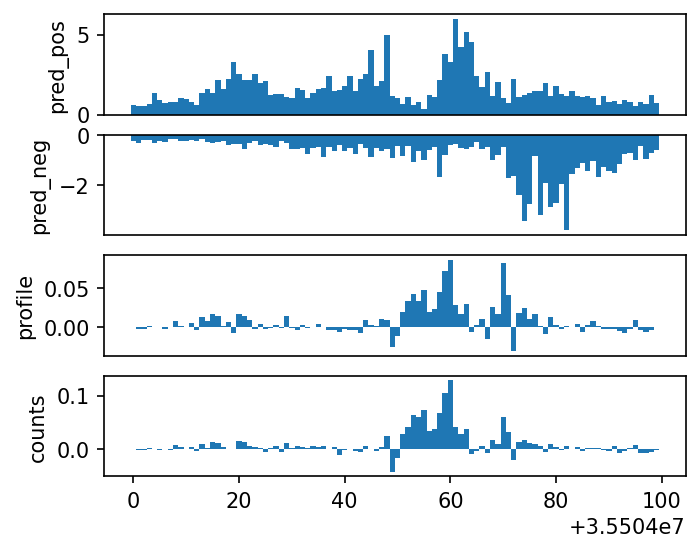

In [119]:
plotShapBigwigs("nanog", "residual", startPos = 35504000, span=100, chrom="chr17")

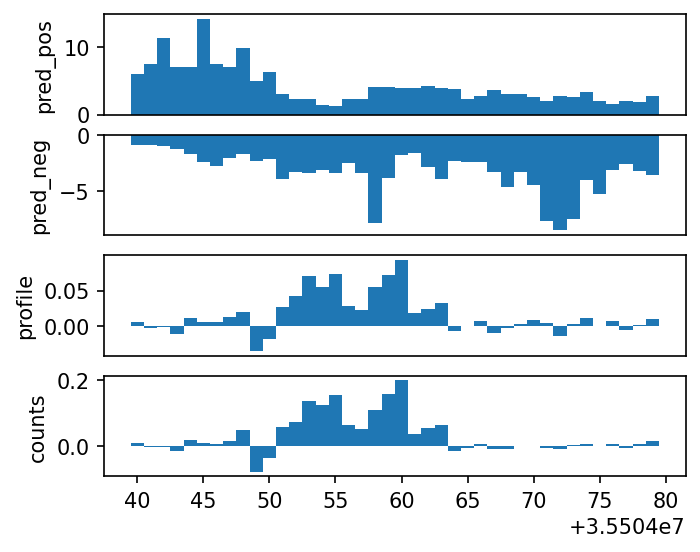

In [121]:
plotShapBigwigs('oct4', 'residual', startPos = 35504040, span=40, chrom="chr17")

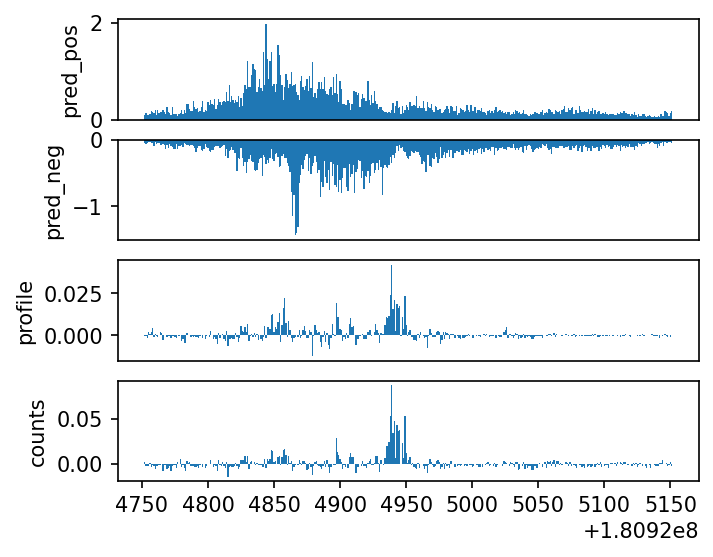

In [117]:
plotShapBigwigs('nanog', 'residual', startPos = 180924752, span=400)

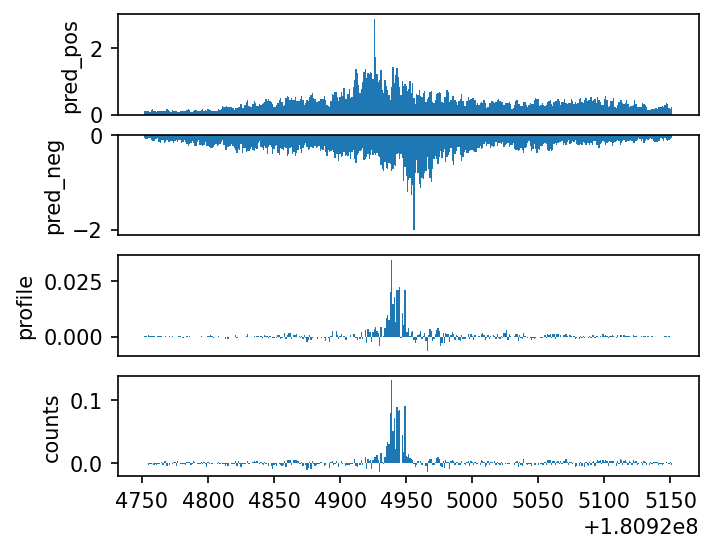

In [120]:
plotShapBigwigs('oct4', 'residual', startPos = 180924752, span=400)

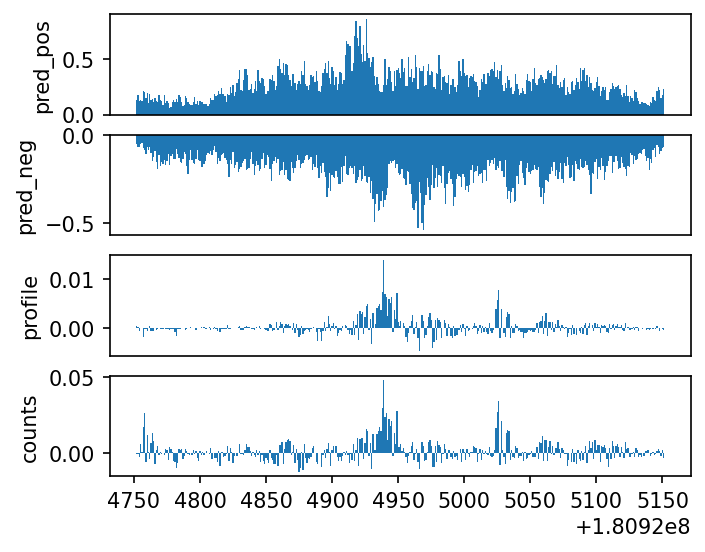

In [114]:
plotShapBigwigs('klf4', 'residual', startPos = 180924752, span=400)

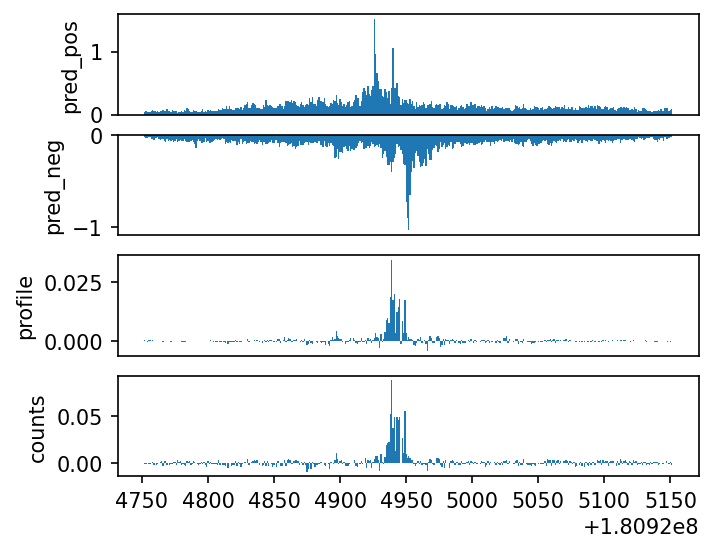

In [115]:
plotShapBigwigs('sox2', 'residual', startPos = 180924752, span=400)

In [83]:
#I'd like to know the distribution of importance scores. 
def plotHistogram(bwName, chrom, start, stop):
    fp = pyBigWig.open(bwName, "r")
    dats = np.array(fp.values(chrom, start, stop))
    fp.close()
    validDats = dats[~np.isnan(dats)]
    validDats = np.abs(validDats)
    validDats = np.log10(validDats+1e-6)
    hist,edges = np.histogram(validDats, bins=100)
    plt.semilogy((edges[:-1] + edges[1:]) / 2, hist, '.')
    plt.xlabel("log10(importance)")
    plt.ylabel("Frequency")

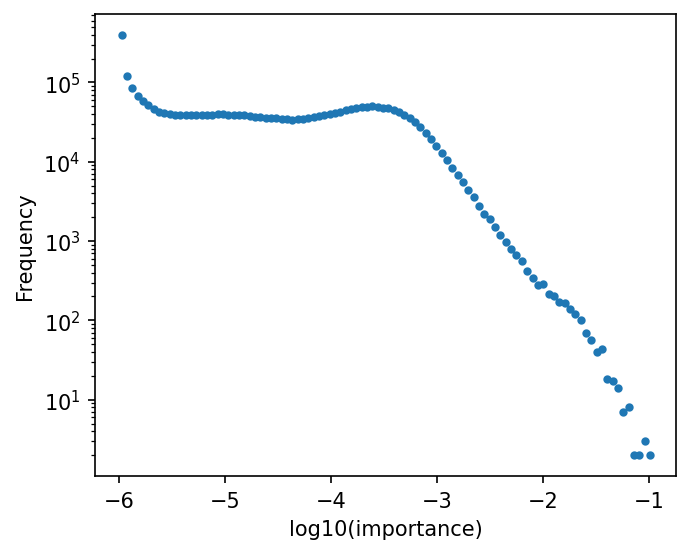

In [84]:
plotHistogram(WORKING_DIRECTORY + "/shap/oct4_profile.bw", "chr1", 10000000, 50000000)

In [ ]:
#Great, so we have those bigwigs and the importance hdf5. I can run Modisco, but I'm going to use a non-GPU server for that. 
#Here's what the command would be, though:

MODISCO_WORKING_DIRECTORY = "/n/projects/cm2363/scratch/oskn-modisco"

for tf in TF_NAMES:
    for readout in ["counts", "profile"]:
        modiscoConfig = {"output-dir" : MODISCO_WORKING_DIRECTORY + "/modisco/" + tf + "_" + readout, 
                         "shap-h5" :    MODISCO_WORKING_DIRECTORY + "/shap/" + tf + "_" + readout + ".h5",
                         "center-cut-size" : 500,
                         "sliding-window-size" : 20,
                         "flank-size" : 5,
                         "num-cores" : 40, 
                         "target-seqlet-fdr" : 0.05,
                         "final-min-cluster-size" : 50,
                         "max-seqlets-per-metacluster" : 20000,
                         "verbosity" : "WARNING"}
        with open(MODISCO_WORKING_DIRECTORY + "/json/modisco_" + tf + "_" + readout + ".json", "w") as fp:
            json.dump(modiscoConfig, fp)
        #!{SRC_DIR}/runModisco.py {MODISCO_WORKING_DIRECTORY}/json/modisco_{tf}_{readout}.json

In [ ]:
#I'm not going further with MoDISco in this notebook, but there will be a hitmapping tool in the future. 

# Making a PISA plot

In [129]:
#In order to make a pisa plot, I need to get a list of regions I want to analyze. The way the PISA script works is that I give it a fasta-format file
#of genomic regions, each region being INPUT_LENGTH long. The PISA tool will then assign contributions to all of the bases in the input relative to the 
#*leftmost* base in the output. 
#This is important, so let me phrase it differently:



#|<- Receptive field ->|
#INPUTSEQUENCEINPUTSEQUENCEINPUTSEQUENCEINPUTSEQUENCE
#\                     /                            /
#  \                 /                            /
#    \             /                            /
#      \         /                            /
#        \     /                            /
#          \ /                            /
#           OUTPUTPROFILEOUTPUTPROFILEOUTP
#           ^
#           | This O is the base that will be used to calculate the contribution scores. 
#It's important to not have any off-by-one problems here, so let's work it out manually. 
print(INPUT_LENGTH)
print(RECEPTIVE_FIELD)

3092
2093


In [130]:
#Since I don't feel like doing ascii art that's quite so wide, I'm going to say that the network is quite a bit smaller:
!{SRC_DIR}/lengthCalc.py --output-len 20 --n-dil-layers 3 --conv1-kernel-size 3 --profile-kernel-size 3

52


In [ ]:
#So in this example the receptive field would be 52-20+1=33. 
#And there are 16 bases of slop on each side that need to be seen by the model. 
#-30     -20       -10         0        10        20        30        40        50
#V         V         V         V         V         V         V         V         V
#098765432109876543210987654321012345678901234567890123456789012345678901234567890123456789
#Output:                       01234567890123456789
#Input:        6543210987654321012345678901234567890123456789012345
#Receptive:    654321098765432101234567890123456

#So in this case, if we want shap scores for a base at position zero, we need sequence from -16 to +35 (inclusive)

In [131]:
windowStart = 180924752

In [132]:
#So I need to get windows that are 3092 bases wide, and the first 2093 bases are the only ones that have a chance of affecting the output
#(since that's the receptive field for the first base.)
#The slop is (2093-1)/2 = 1046
#I want to shap starting at chr1:180924752 and I want to take 400 bases worth of calculations. 
def writeRegion(genome, outFp, regionStart):
    genomeStart = regionStart - 1046
    genomeEnd = genomeStart + INPUT_LENGTH
    seq = genome.fetch("chr1", genomeStart, genomeEnd)
    outFp.write(">{0:d}\n".format(regionStart))
    outFp.write(seq.upper())
    outFp.write("\n")

with open(WORKING_DIRECTORY + "/shap/pisa_regions.fa", "w") as fp:
    with pysam.FastaFile(GENOME_FASTA) as genome:
        for regionStart in range(windowStart, windowStart + 400):
            writeRegion(genome, fp, regionStart)
    


In [133]:
#And now we bulid the json file for the PISA analysis.
for tfid in [0,3]:
    for strand in [0,1]:
        task_name = TF_NAMES[tfid] + "_" + ["positive", "negative"][strand]
        pisa_config = {"model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
                       "sequence-fasta" : WORKING_DIRECTORY + "/shap/pisa_regions.fa", 
                       "num-shuffles" : 20, 
                       "head-id" : tfid, #(That's the nanog head)
                       "task-id" : strand,
                       "output-h5" : WORKING_DIRECTORY + "/shap/pisa_" + task_name + ".h5",
                       "output-length" : OUTPUT_LENGTH,
                       "make-predictions" : True,
                       "verbosity" : "DEBUG"}

        with open(WORKING_DIRECTORY + "/json/pisa_" + task_name + ".json", "w") as fp:
            json.dump(pisa_config, fp)
        !{SRC_DIR}/interpretPisaFasta.py {WORKING_DIRECTORY}/json/pisa_{task_name}.json

INFO:root:GPU memory growth enabled.
INFO:root:Predicting sequences and their shuffles...
  0%|                                                   | 0/400 [00:00<?, ?it/s]/n/projects/cm2363/utils/src/anaconda3/envs/bpreveal/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
100%|█████████████████████████████████████████| 400/400 [00:13<00:00, 29.30it/s]


INFO:root:AddV2used in model but handling of op is not specified by shap; will use original  gradients
INFO:root:SpaceToBatchNDused in model but handling of op is not specified by shap; will use original  gradients
INFO:root:BatchToSpaceNDused in model but handling of op is not specified by shap; will use original  gradients
100%|█████████████████████████████████████████| 400/400 [00:17<00:00, 22.84it/s]
INFO:root:GPU memory growth e

In [134]:
#Let's take a look at the pisa results! 
with h5py.File(WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5", "r") as fp:
    pisaDescriptions = list(fp["descriptions"])
    pisaSequences = np.array(fp["sequence"])
    pisaShap = np.array(fp["shap"])
    pisaInputPred = np.array(fp["input_predictions"])
    pisaInputPred = np.array(fp["shuffle_predictions"])

In [135]:
pisaVals = np.sum(pisaShap,axis=2)
print(pisaVals.shape)

(400, 2092)


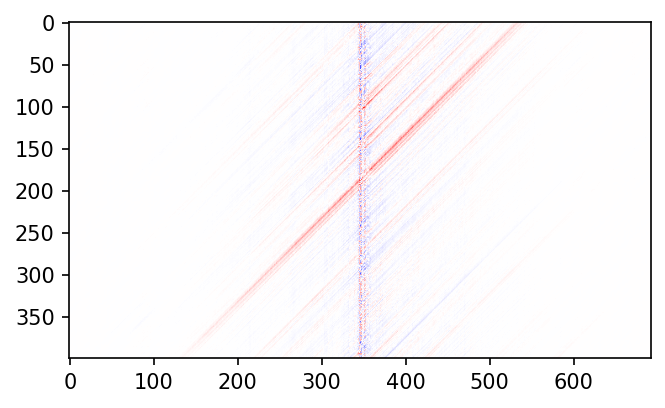

In [136]:
pisaSpan = 0.4
plt.imshow(pisaVals[:,700:-700], vmin=-pisaSpan, vmax=pisaSpan, cmap='bwr')


In [170]:
#The axes can be kind of hard to interpret on a pisa plot, so I'm going to shear it real quick. 
def plotPisa(taskName, cutMiddle, cutLengthX, cutLengthY, colorSpan=1.0): 
    with h5py.File(WORKING_DIRECTORY + "/shap/pisa_" + taskName + ".h5", "r") as fp:
        pisaShap = np.array(fp["shap"])
    pisaVals = np.sum(pisaShap,axis=2)
    numRegions = pisaVals.shape[0]
    shearMat = np.zeros((numRegions, pisaVals.shape[1] + numRegions))
    for i in range(0, numRegions):
        offset = i
        shearMat[i, offset:offset+pisaVals.shape[1]] = pisaVals[i]
    print(shearMat.shape)
    cutStartX = cutMiddle-cutLengthX//2
    cutStartY = cutMiddle - cutLengthY//2
    plotMat = shearMat[cutStartY:cutStartY + cutLengthY,RECEPTIVE_FIELD//2+cutStartX:RECEPTIVE_FIELD//2+cutStartX + cutLengthX]
    axStartY = (cutLengthX - cutLengthY)//2
    axStopY = axStartY + cutLengthY
    extent=[0, cutLengthX, axStopY, axStartY]
    plt.imshow(plotMat, vmin=-colorSpan, vmax=colorSpan, extent=extent, cmap='RdBu_r', aspect='auto', interpolation='nearest')
    #And let's get the sequence for that:
    plt.plot([0,cutLengthX], [0,cutLengthX], 'k--', lw=0.5)
    if(cutLengthX < 40):
        with pysam.FastaFile(GENOME_FASTA) as genome:
            seq = genome.fetch("chr1", windowStart+cutStartX, windowStart+cutStartX + cutLengthX)
            print(seq)
        plt.xticks(range(0,cutLengthX), labels=seq);

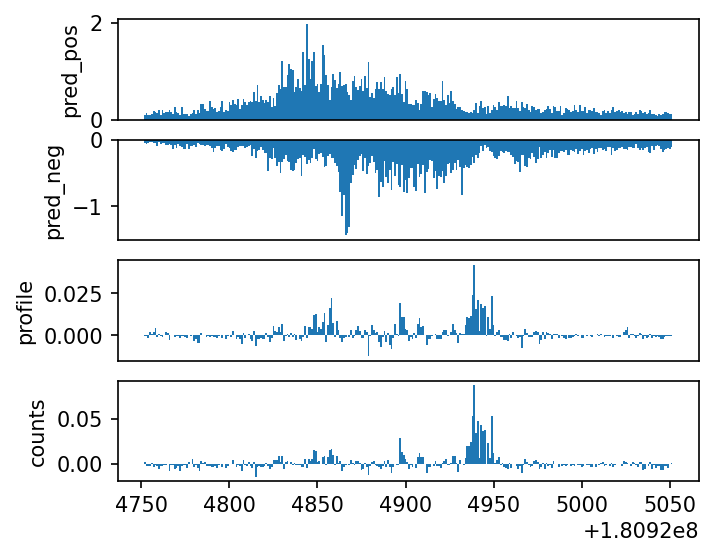

In [138]:
#Let's remind ourselves of what the nanog binding looked like...
plotShapBigwigs('nanog', 'residual', startPos = windowStart, span=300)

(400, 2492)
(400, 2492)


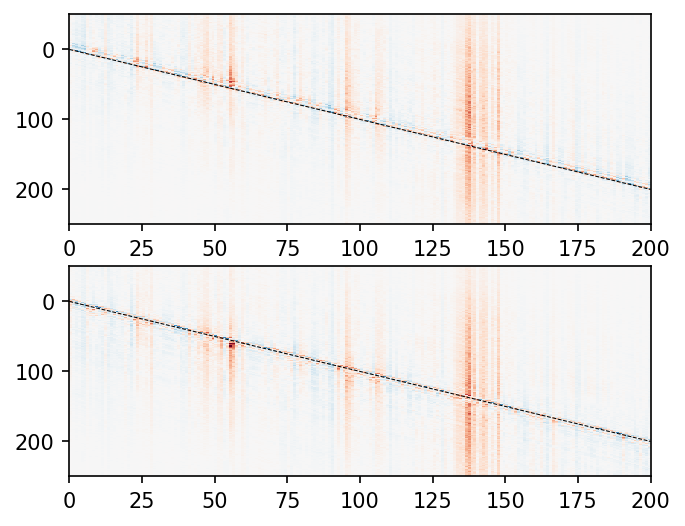

In [174]:
plt.subplot(211)
plotPisa("nanog_positive", 150, 200, 300, colorSpan = 0.5)

plt.subplot(212)
plotPisa("nanog_negative", 150, 200, 300, colorSpan = 0.5)

(400, 2492)
GTAATTGACCAATCAGCCAGGGGGAAGTGA
(400, 2492)
GTAATTGACCAATCAGCCAGGGGGAAGTGA


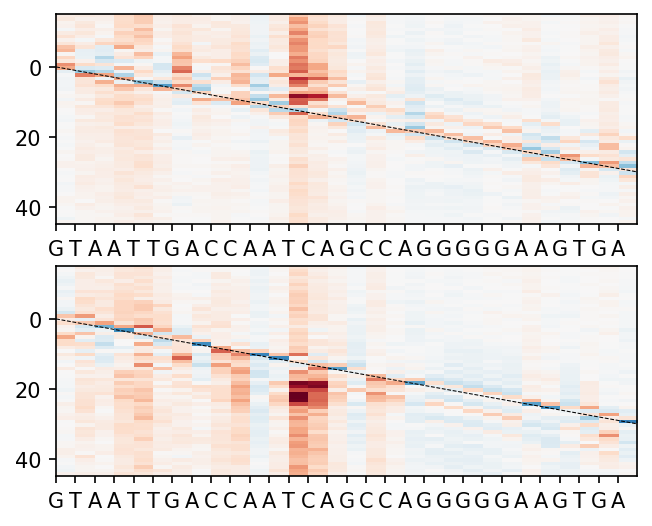

In [172]:
#One thing is pretty striking. The motif at ~100 bp has a directional effect, that is, the importance toward the positive peak is upstream of the 
#motif and the importance of the negative peak is downstream. But the motif at ~190 doesn't seem to be directional, and it seems to have a larger 
#reach. Let's zoom in! 
plt.subplot(211)
plotPisa("nanog_positive", 108, 30, 60, colorSpan = 0.5)
plt.subplot(212)
plotPisa("nanog_negative", 108, 30, 60, colorSpan = 0.5)

(400, 2492)
GAGACTGCCCTTTGTCATGTAGAAGGAGCT
(400, 2492)
GAGACTGCCCTTTGTCATGTAGAAGGAGCT


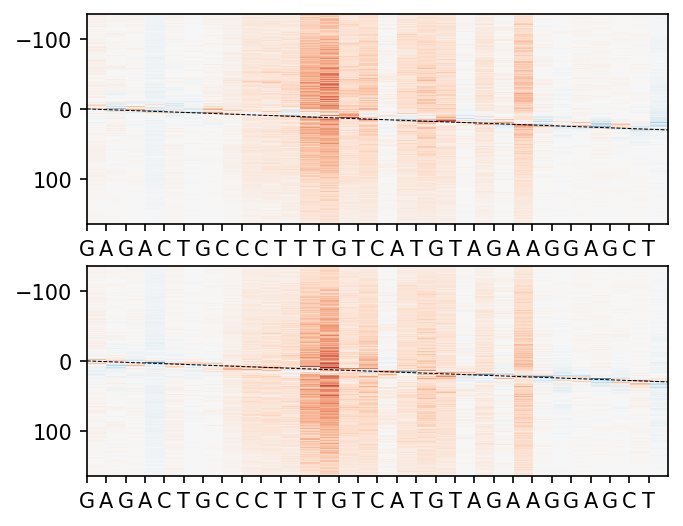

In [173]:
plt.subplot(211)
plotPisa("nanog_positive", 190, 30, 300, colorSpan = 0.5)
plt.subplot(212)
plotPisa("nanog_negative", 190, 30, 300, colorSpan = 0.5)

In [ ]:
#Indeed, this motif looks very different! 

(400, 2492)
(400, 2492)


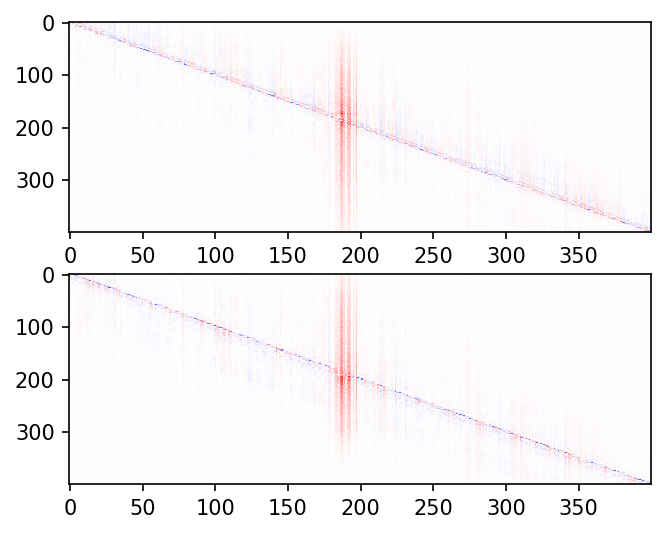

In [142]:
plt.subplot(211)
plotPisa("oct4_positive", 200, 400, 400, colorSpan = 0.5)
plt.subplot(212)
plotPisa("oct4_negative", 200, 400, 400, colorSpan = 0.5)

In [ ]:
#Ah, that might explain why the motif acts differently - it's a motif for a different protein altogether! Let's zoom in on the Oct4 motif. 

(400, 2492)
GAGACTGCCCTTTGTCATGTAGAAGGAGCT
(400, 2492)
GAGACTGCCCTTTGTCATGTAGAAGGAGCT


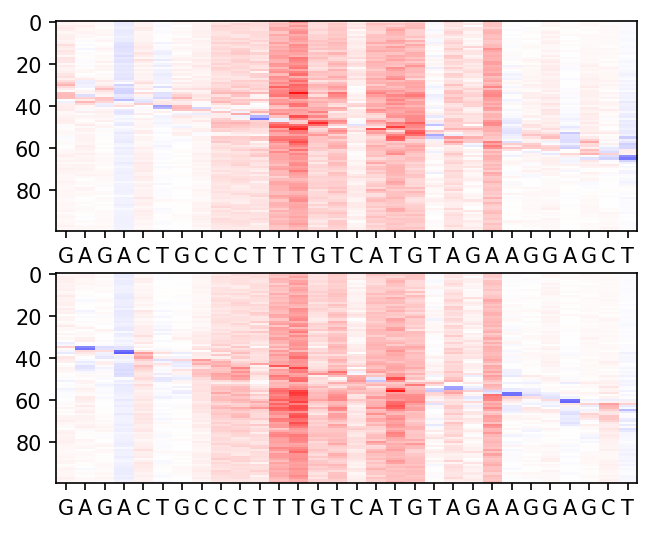

In [143]:
plt.subplot(211)
plotPisa("oct4_positive", 190, 30, 100, colorSpan = 0.5)
plt.subplot(212)
plotPisa("oct4_negative", 190, 30, 100, colorSpan = 0.5)

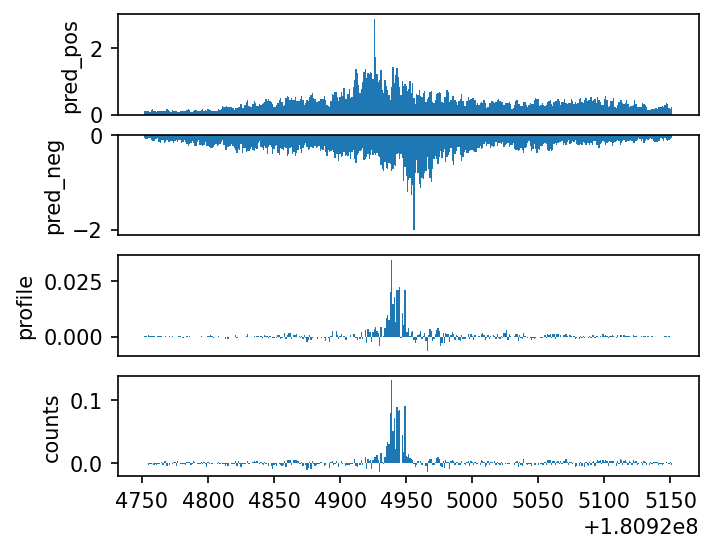

In [144]:
#As a reminder, let me pull up the Oct4 tracks:
plotShapBigwigs('oct4', 'residual', startPos = 180924752, span=400)

In [145]:
cutMiddle=100
cutLengthX = 30
cutLengthY = 150
cutStartX = cutMiddle-cutLengthX//2
cutStartY = cutMiddle - cutLengthY//2
plotMat = shearMat[cutStartY:cutStartY + cutLengthY,RECEPTIVE_FIELD//2+cutStartX:RECEPTIVE_FIELD//2+cutStartX + cutLengthX]
plt.imshow(plotMat, vmin=-pisaSpan, vmax=pisaSpan, cmap='bwr', aspect='auto')
#And let's get the sequence for that:
with pysam.FastaFile(GENOME_FASTA) as genome:
    seq = genome.fetch("chr1", windowStart+cutStartX, windowStart+cutStartX + cutLengthX)
    print(seq)
plt.xticks(range(0,cutLengthX), labels=seq)

True

NameError: name 'shearMat' is not defined

In [ ]:
cutMiddle=190
cutLengthX = 30
cutLengthY = 150
cutStartX = cutMiddle-cutLengthX//2
cutStartY = cutMiddle - cutLengthY//2
plotMat = shearMat[cutStartY:cutStartY + cutLengthY,RECEPTIVE_FIELD//2+cutStartX:RECEPTIVE_FIELD//2+cutStartX + cutLengthX]
plt.imshow(plotMat, vmin=-pisaSpan, vmax=pisaSpan, cmap='bwr', aspect='auto')
#And let's get the sequence for that:
with pysam.FastaFile(GENOME_FASTA) as genome:
    seq = genome.fetch("chr1", windowStart+cutStartX, windowStart+cutStartX + cutLengthX)
    print(seq)
plt.xticks(range(0,cutLengthX), labels=seq);